# Introduction
This is the random forest learner associated with Voter Analysis.
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# DETERMINE IF YOU ARE USING RAW OR SCALED
Scaled is Zhao's data, continuous variables divided by standard deviation
<br>Raw is unscaled raw data

In [2]:
useRaw=False
outdir = 'outBElectionResultsScaled2'
filename='results.csv'
filename_all = 'results_complete.csv'
filename_model_params = "RF_model_params.sav"
os.makedirs(outdir, exist_ok=True)

In [3]:
#get the data
if (useRaw == True):
    df = pd.read_csv('./data/ccesplus.csv',encoding = "ISO-8859-1")
else:
    df = pd.read_csv('./data/ccesplus_fscaled.csv',encoding = "ISO-8859-1")

In [4]:
df.head()

,cc.countyfips,cc.V101,cc.commonweight_vv,cc.commonweight_vv_post,cc.commonweight_vv_lgbt,cc.commonweight,cc.commonweight_post,cc.tookpost,cc.lookupzip,cc.inputstate,cc.cdid113,cc.cdid115,cc.countyname,cc.CurrentGovName,cc.CurrentGovParty,cc.CurrentHouseGender,cc.CurrentHouseName,cc.CurrentHouseParty,cc.CurrentSen1Gender,cc.CurrentSen1Name,cc.CurrentSen1Party,cc.CurrentSen2Gender,cc.CurrentSen2Name,cc.CurrentSen2Party,cc.GovCand1Incumbent,cc.GovCand1Name,cc.GovCand1Party,cc.GovCand2Incumbent,cc.GovCand2Name,cc.GovCand2Party,...,dr.marg.2012,dr.pmarg.2012,dr.ratio.2016,dr.marg.2016,dr.pmarg.2016,pmarg.dif12,pmarg.dif8,marg.dif12,marg.dif8,ratio.dif12,ratio.dif8,RepClosedP,RepPMarch15,TrumpCarson,TrumpKasich,TrumpCruz,TrumpStrength,relig.tot.pc,relig.evan.pc,relig.cath.pc,relig.orth.pc,relig.oth.pc,relig.lds.pc,relig.mslm.pc,relig.ojud.pc,relig.majprt.pc,relig.majchr.pc,relig.bud.pc,relig.hind.pc,demo.popdense
0,NaN,0.990165,0.490168,0.358252,0.415116,0.392297,0.313699,1,1.710309,1.270698,0.293357,0.293375,,Kate Brown,Democratic,M,Peter DeFazio,Democratic,M,Ron Wyden,Democratic,M,Jeff Merkley,Democratic,1,Kate Brown,Democratic,0,Bud Pierce,Republican,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.993253,0.567879,0.470839,0.524566,0.544645,0.516661,1,1.702097,1.270698,0.073339,0.073344,,Kate Brown,Democratic,F,Suzanne Bonamici,Democratic,M,Ron Wyden,Democratic,M,Jeff Merkley,Democratic,1,Kate Brown,Democratic,0,Bud Pierce,Republican,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.996015,4.925791,NaN,NaN,8.213954,0.000000,0,1.504748,0.123970,0.146678,0.146687,,Doug Ducey,Republican,F,Martha McSally,Republican,M,John McCain,Republican,M,Jeff Flake,Republican,0,,,0,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.996495,0.758395,NaN,0.465872,0.494493,0.000000,0,1.476199,1.518639,0.293357,0.293375,,Gary Herbert,Republican,F,Mia Love,Republican,M,Orrin Hatch,Republican,M,Mike Lee,Republican,0,Mike Weinholtz,Democratic,1,Gary R. Herbert,Republican,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.996763,0.531301,0.385797,0.445813,0.482130,0.396884,1,1.714380,1.270698,0.146678,0.146687,,Kate Brown,Democratic,M,Greg Walden,Republican,M,Ron Wyden,Democratic,M,Jeff Merkley,Democratic,1,Kate Brown,Democratic,0,Bud Pierce,Republican,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Load train/test
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [5]:
os.makedirs('tmp', exist_ok=True)

trnfile = 'tmp/trn_regid31'
tstfile = 'tmp/tst_regid31'
jsonfile = 'tmp/catcont_regid31.json'

if (useRaw == True):
    trnfile = 'tmp/trn_regid31_raw'
    tstfile = 'tmp/tst_regid31_raw'
    jsonfile = 'tmp/catcont_regid31_raw.json'

In [6]:
#get processed training and test data
trn_raw = pd.read_feather(trnfile)
tst_raw = pd.read_feather(tstfile)

trn = trn_raw.copy()
tst = tst_raw.copy()

# columns_dep_var= 'cc.vote16'

## Get the original indexes of train and tst
Use these to merge results back to original dataset

In [7]:
trn_indexes = trn_raw[['index']].copy()
tst_indexes = tst_raw[['index']].copy()
trn_indexes.head()
tst_indexes.head()

,index
0,41774
1,7379
2,31139
3,10588
4,23391


,index
0,61820
1,62831
2,28306
3,14141
4,18323


In [8]:
#delete the index column from trn and tst
trn_raw =trn_raw.drop('index',axis=1)
tst_raw =tst_raw.drop('index',axis=1)

In [9]:
all_indexes = trn_indexes.copy().append(tst_indexes.copy(), ignore_index=True)
print(f"Have {len(trn_indexes)} train, {len(tst_indexes)} test, {len(all_indexes)}")

Have 57888 train, 6432 test, 64320


In [10]:
type(all_indexes)

pandas.core.frame.DataFrame

In [11]:
type(all_indexes)

pandas.core.frame.DataFrame

In [12]:
trn_raw.head()
tst_raw.head()

,cc.vote16,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_3,cc.CC16_305_2,cc.CC16_305_1,cc.CC16_305_7,cc.CC16_305_5,cc.CC16_305_11,cc.CC16_305_6,cc.CC16_305_9,cc.CC16_305_10,cc.CC16_305_4,cc.fortunesum,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.citylength_1,cc.isimmigrant,cc.child18,cc.milstat_1,cc.milstat_3,cc.union,cc.CC16_300_5,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,eth.his.p,relig.evan.pc,demo.popdense,cc.RepDum,cc.IndDum
0,2,0,0.631982,0.421638,1.555567,2.997609,0.955437,0.746187,1.124623,2.365855,0,0,0,1,0,1,0,0,0,0,1.739794,0.722408,0.850569,0.855920,0.887577,0.0,0.709315,1,1,0,0,0.044401,1,1.0,1.004098,1.047055,0.0,1,0.431581,0.902155,0.0,0.0,0.814553,0.525258,1.139161,0.042193,0.0,0.0
1,0,1,0.947973,0.983823,0.486994,0.283530,0.997454,1.108232,0.867162,0.277401,0,0,0,0,0,0,0,0,0,1,0.869897,1.172766,0.425285,NaN,0.295859,NaN,0.886644,0,0,1,0,0.888018,1,0.0,0.502049,1.047055,0.0,0,3.021067,1.578771,1.0,0.0,0.995565,1.488613,0.506771,0.087779,1.0,0.0
2,2,0,0.631982,0.843277,0.728483,0.645397,0.747177,1.121927,0.686091,0.753709,0,0,0,0,0,0,0,0,0,1,0.869897,1.034503,0.425285,0.855920,1.183436,0.0,1.458036,0,0,1,1,2.131244,0,0.0,1.004098,1.047055,0.0,0,0.431581,0.676616,0.0,1.0,1.357588,0.308885,0.729800,0.248592,0.0,0.0
3,1,0,0.947973,0.843277,0.673498,1.074265,1.063220,1.072834,0.775212,0.580976,0,0,0,0,0,0,0,0,1,0,-0.869897,0.905313,1.701138,1.069900,1.183436,1.0,1.458036,1,0,1,0,1.598433,0,0.0,1.004098,1.047055,1.0,0,1.294743,1.578771,1.0,0.0,1.448094,0.721752,0.201437,0.166523,1.0,0.0
4,1,0,1.263963,0.562184,1.321577,0.276227,0.639394,0.887516,0.773797,0.098916,0,0,0,0,0,0,0,0,1,0,-0.869897,0.747420,1.701138,1.283881,1.183436,1.0,1.182192,0,0,1,0,1.376428,0,0.0,1.004098,0.523528,0.0,1,0.431581,1.578771,1.0,0.0,0.905059,0.310414,0.633215,0.011432,0.0,1.0


,cc.vote16,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_3,cc.CC16_305_2,cc.CC16_305_1,cc.CC16_305_7,cc.CC16_305_5,cc.CC16_305_11,cc.CC16_305_6,cc.CC16_305_9,cc.CC16_305_10,cc.CC16_305_4,cc.fortunesum,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.citylength_1,cc.isimmigrant,cc.child18,cc.milstat_1,cc.milstat_3,cc.union,cc.CC16_300_5,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,eth.his.p,relig.evan.pc,demo.popdense,cc.RepDum,cc.IndDum
0,0,0,0.631982,0.562184,0.491484,0.921370,0.747177,1.268452,0.591311,0.714095,1,0,0,0,0,0,0,0,0,0,0.869897,1.250706,0.000000,NaN,0.887577,0.0,0.453173,1,0,1,1,1.021221,0,0.0,1.004098,1.047055,0.0,1,3.021067,1.127693,1.0,0.0,1.538600,0.414396,0.549482,0.110087,0.0,1.0
1,0,0,0.947973,0.702731,1.748649,2.739953,0.982839,0.623374,0.862918,0.000000,0,0,0,0,1,1,0,0,1,0,-0.869897,0.636006,0.850569,0.962910,0.887577,0.0,0.531986,1,0,1,0,0.044401,1,1.0,1.004098,1.047055,0.0,1,0.863162,NaN,0.0,0.0,0.995565,0.161324,1.368086,0.002795,0.0,1.0
2,1,0,0.947973,0.983823,0.060405,0.017449,0.933515,1.305075,0.466825,0.143210,0,0,0,0,0,0,0,0,0,0,0.000000,1.026557,0.850569,1.283881,0.887577,0.0,1.162489,0,0,1,0,1.376428,0,0.0,1.004098,1.047055,1.0,1,0.431581,1.353232,0.0,1.0,1.176576,0.154443,0.137955,0.088558,0.0,1.0
3,0,0,0.631982,1.546007,0.455221,0.519311,1.143601,0.751167,1.369353,0.377039,0,0,1,1,0,0,1,0,0,0,2.609691,0.619558,0.425285,NaN,0.887577,1.0,0.729018,1,0,0,1,0.355207,1,1.0,1.004098,1.047055,1.0,1,1.294743,0.451077,1.0,1.0,0.995565,2.990223,0.564938,0.158463,0.0,0.0
4,2,0,0.631982,1.827100,0.477007,0.193115,0.993800,0.904360,1.110477,0.000000,0,0,0,0,0,0,0,0,1,1,0.000000,0.935057,0.000000,0.427960,0.887577,0.0,1.280708,0,0,1,0,0.133203,0,0.0,1.004098,0.523528,1.0,1,0.431581,0.451077,0.0,0.0,0.271518,0.546666,0.457018,0.005463,0.0,0.0


## Get continuous and categorical variables, convert dependant variable to int64

In [13]:
#get continuous and categorical variables
with open(jsonfile) as f:
    data1 = json.load(f)
    res_cont = data1[0]
    res_cat = data1[1] 
    columns_dep_var = data1[2][0]
   
# res_cont
# res_cat

In [14]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [15]:
#convert trumpgevote to long (otherwise fit fails)
trn[columns_dep_var] = trn[columns_dep_var].astype('int64');
tst[columns_dep_var] = tst[columns_dep_var].astype('int64');

print(str(len(trn)))
print(str(len(tst)))

57888
6432


## Lets see what features are corelated with each other

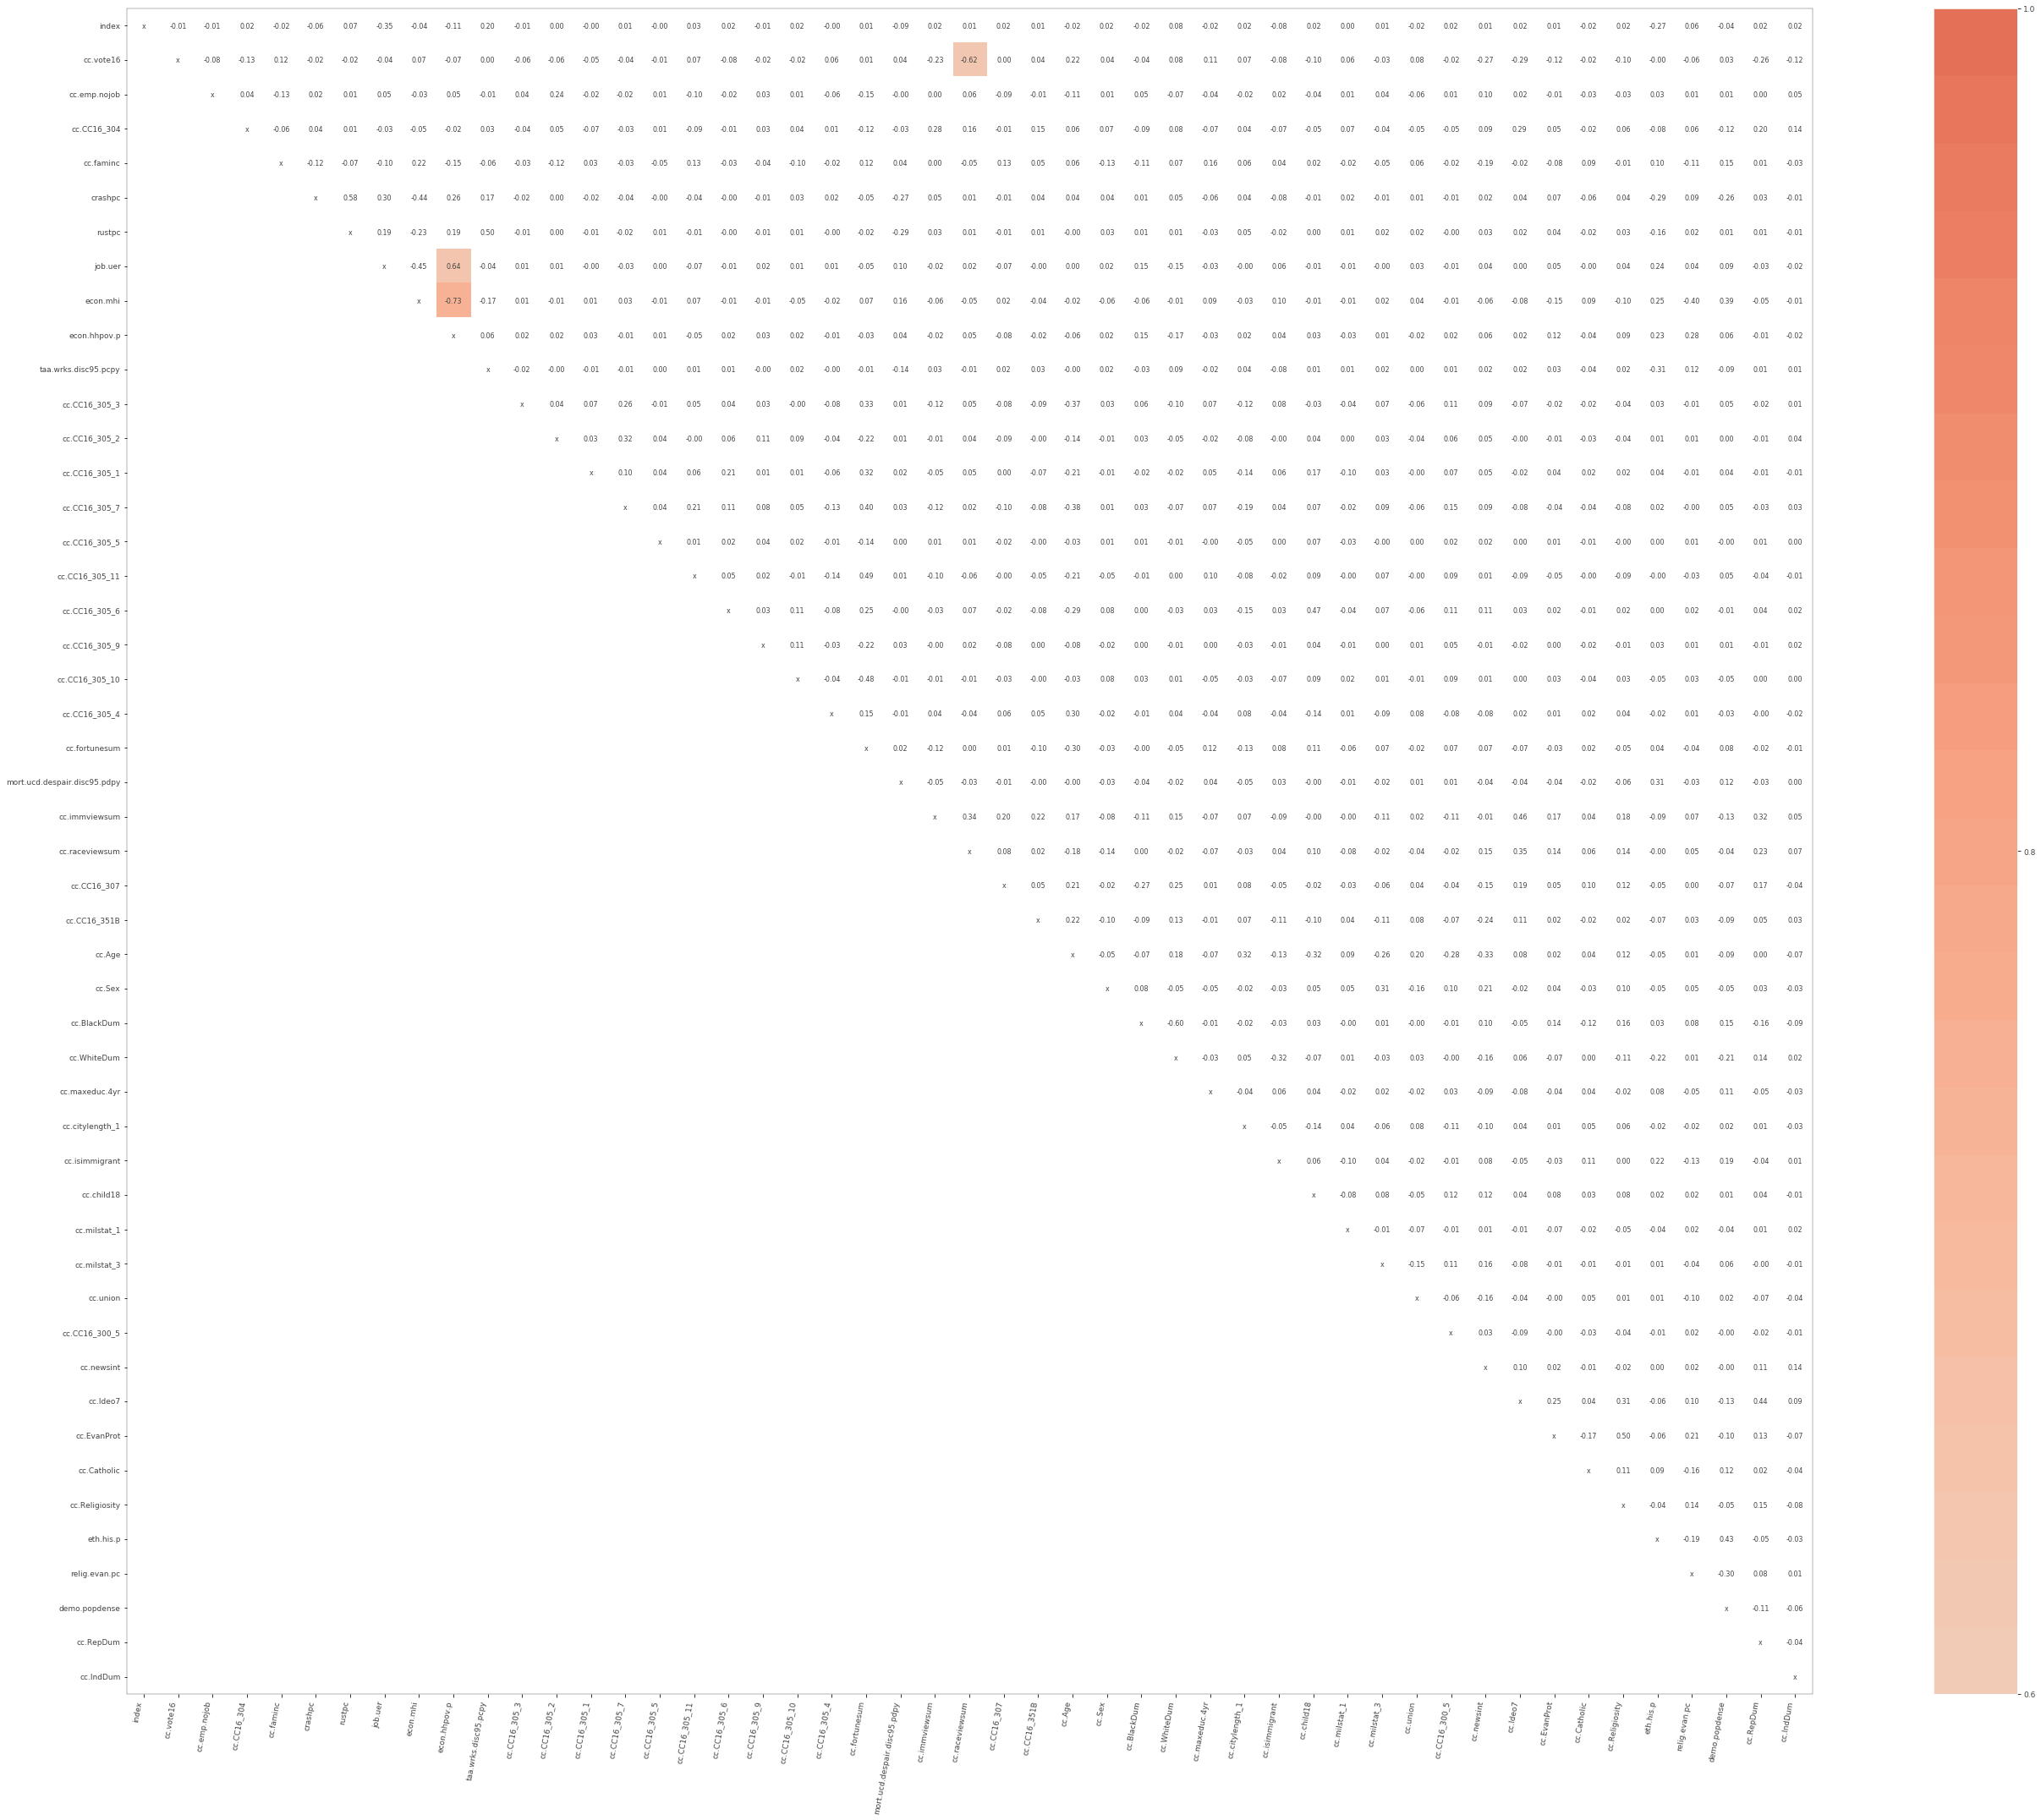

In [16]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(trn, figsize=(50,30))
viz.view()

## Categorify and Fill Missing

In [17]:
#from docs https://docs.fast.ai/tabular.transform.html
tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
tfm(trn)
tfm(tst)

In [18]:
#just checking to see if it works on any old variable
trn[res_cat[0]].cat.categories
tst[res_cat[0]].cat.categories

Int64Index([0, 1], dtype='int64')

Int64Index([0, 1], dtype='int64')

In [19]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(trn)
tfm1(tst)

## Clean up any missing columns that result from unfortunate test selection

In [20]:
trn_y=trn[columns_dep_var].copy()
trn=trn.drop(columns_dep_var,axis=1)

tst_y=tst[columns_dep_var].copy()
tst=tst.drop(columns_dep_var,axis=1)

# trn.T
# trn_y

In [21]:
#You cannot have any Nan (missing data) fields or random forest will not work.
print(f"Total trn columns = {len(trn.columns)}, total tst columns = {len(tst.columns)}") 
print(f"Total trn columns with Nans= {len(trn.columns[trn.isnull().any()])}") #add ~ to get columns with no missing values
print(f"Total tst columns with Nans= {len(tst.columns[tst.isnull().any()])}") #add ~ to get columns with no missing values

Total trn columns = 48, total tst columns = 48
Total trn columns with Nans= 0
Total tst columns with Nans= 0


In [22]:
#hmmm if either has 1 more column than train then see what it is
set(tst.columns)-set(trn.columns)
set(trn.columns)-set(tst.columns)

#missing one of the _na columns.  This is added, and set to 1, when a variable has an NaN value to mark
#columns that have NaNs

#find the index of the column in trn
# idx=trn.columns.tolist().index('cc.catholic_na')
# idx
# type(trn.columns)

# tst.insert(loc=idx, column='cc.catholic_na', value=False)

set()

set()

# Train a RandomForest on all data

In [23]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

#create a random forest object
m_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=10)

In [24]:

def rmse(x,y): 
    '''this and R**2 used for continuous variables'''
    return math.sqrt(((x-y)**2).mean())

def print_score(m, trn, trn_y, tst, tst_y):
    '''
    
    '''
    res = [m.score(trn, trn_y), m.score(tst, tst_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [25]:
#train the random forest 
m_rf.fit(trn, trn_y)

print_score(m_rf, trn, trn_y, tst, tst_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

[0.8099433388612494, 0.7583955223880597, 0.7545087064676617]


# Test the model on test data

In [26]:
def eval_accuracy(preds,targs, silent=True):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    acc=100*matches/totals 
    if( silent == False):
        print(f"Got {matches} right out of {totals} samples, Accuracy is {acc} percent")
    return acc

In [27]:
preds1 = m_rf.predict(tst)

eval_accuracy(preds1,tst_y,silent=False);

Got 4878 right out of 6432 samples, Accuracy is 75.83955223880596 percent


# Which features are important
How is the model making predictions?  What matters?  What features give the most information gain?

Use this information to select only relevant features to train the model on, this simplifies the model while preserving accuracy.  And simplicity tends toward better generalization.

## Lets try default Feature importance (flawed scikitlrn implementation)

In [28]:
#copied from fastai structured.py
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [29]:
#lets figure out whats most important (top 20 out of 32)
fi = rf_feat_importance(m_rf, tst);

fi['imp'].sum() #should be 1
fi[:20];

<B>Run section 6 with just the to_keep columns</B>

## Lets try random permutation based feature importance
Should be more accurate but is computationally expensive see <a href="https://explained.ai/rf-importance/index.html#5">Beware Default Random Forest Importances</a>

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from rfpimp import permutation_importances, oob_classifier_accuracy

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

def acc(rf, X_train, y_train):
    return accuracy_score(y_train, rf.predict(X_train))

trn_pb=trn.copy()
trn_pb_y=trn_y.copy()

In [31]:
#the following calculates how each feature affects the result
#First it gets the baseline metric (acc) for the entire set  (trn_pb, trn_pb_y)
#then it permutes a single feature (randomly scrambling that column)
#then calculates the metric (acc) for the entire set (trn_pb, trn_pb_y)
#then it subtracts that from the baseline to see how that metric affects the predictions

feature_importance = permutation_importances(m_rf, trn_pb, trn_pb_y, oob_classifier_accuracy)
# feature_importance_tst = permutation_importances(m_rf, tst.copy(), tst_y.copy(), acc)

The following importance values will not sum up to one, it's important to remember that we don't care what the values are per se. What we care about is the relative predictive strengths of the features. (excerpt from <a href="https://explained.ai/rf-importance/index.html#5">Beware Default Random Forest Importances</a>)

In [32]:
perm_imp_rfpimp = feature_importance.copy().reset_index()

In [33]:
# perm_imp_rfpimp_tst = feature_importance_tst.copy().reset_index()
# # perm_imp_rfpimp.plot(kind='barh',y="Feature", x='Importance', figsize=(12,7), legend=False)
# perm_imp_rfpimp_tst[:30].plot(x='Feature',y='Importance',kind= 'barh', figsize=(12,7), legend=False)

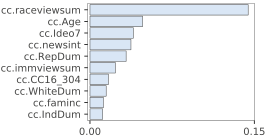

In [34]:
#just another way to plot above (uses OOB)
from rfpimp import plot_importances
plot_importances(feature_importance[:10])
# perm_imp_rfpimp

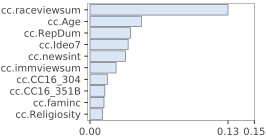

In [35]:
#same as permutation_importances except uses validation set, much, much faster since no loop
from rfpimp import importances
ret = importances(m_rf, trn, trn_y, features=None, n_samples=5000, sort=True, metric=None, sample_weights = None)
plot_importances(ret[:10])

If we have slightly different importances on the training and test sets, this may indicate that the test set and training set may be statisticaly dissimilar

<B>Run section 6 with just the to_keep columns</B>

## Lets try a different library (eli5) random permutation based feature importance
Should be more accurate but is computationally expensive see 

In [36]:
from eli5.sklearn import PermutationImportance
# m2= RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=10)

%time perm = PermutationImportance(m_rf).fit(tst,tst_y)

CPU times: user 2min 18s, sys: 4.91 s, total: 2min 23s
Wall time: 44.3 s


## Try dropcol_importances
train a model over and over, dropping 1 column at a time 

In [37]:
from rfpimp import dropcol_importances

mrf_dc = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            oob_score=True, max_features='auto', min_samples_leaf=10)
mrf_dc.fit(trn, trn_y)

#this will take a while
feature_importanceDC = dropcol_importances(mrf_dc, trn, trn_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [38]:
feature_importanceDC1 = feature_importanceDC.copy().reset_index()

## Show graphs for above methods

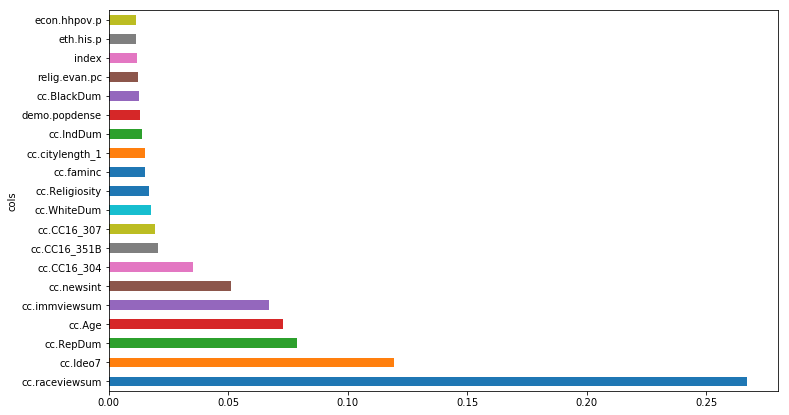

In [39]:
#sklearn
#plot the top 20 for sklearn feature importance based on Gini info gain
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:20]);
# plot_fi(fi[40:]);

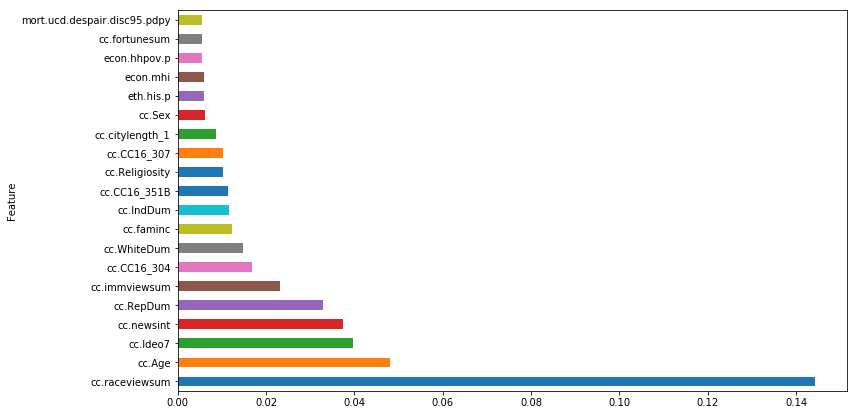

In [40]:
#rfpimp-permutation
#for column permutations
# perm_imp_rfpimp.plot(kind='barh',y="Feature", x='Importance', figsize=(12,7), legend=False)
perm_imp_rfpimp[:20].plot(x='Feature',y='Importance',kind= 'barh', figsize=(12,7), legend=False)

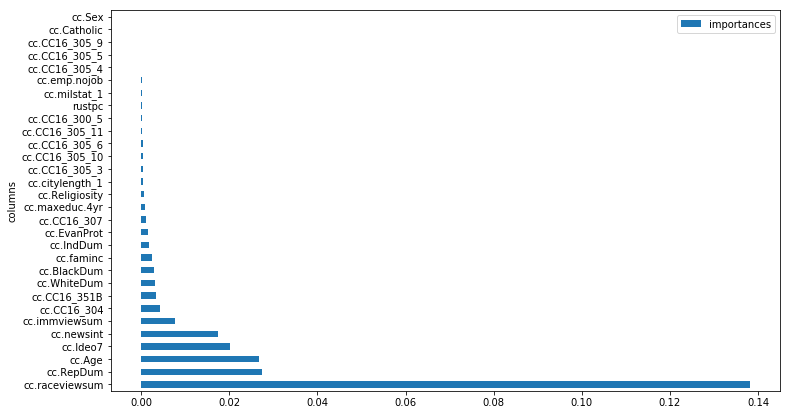

In [41]:
#eli5-permutation WINNER!!
I = pd.DataFrame(data={"columns":tst.columns, "importances":perm.feature_importances_})
I = I.set_index("columns")
I = I.sort_values('importances', ascending=False)
# I
I[:30].plot.barh(figsize=(12,7))
# I[:10].plot(x='columns',y='importances',kind= 'barh', figsize=(12,7), legend=False)

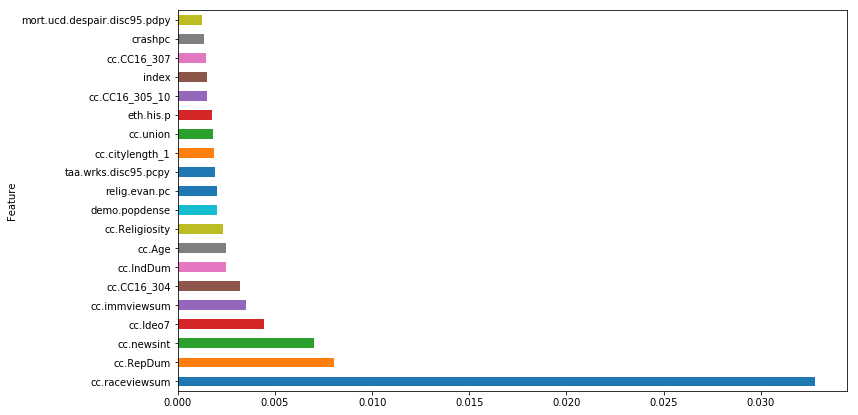

In [42]:
#rfpimp-dropcolumn
#for drop column, if negative you can drop that single column and the model will improve, but that does not mean you can drop all
#of them
# perm_imp_rfpimp.plot(kind='barh',y="Feature", x='Importance', figsize=(12,7), legend=False)
feature_importanceDC1[:20].plot(x='Feature',y='Importance',kind= 'barh', figsize=(12,7), legend=False)

# Train a new RandomForest only on important features (drop others)

In [43]:
def rerunWithFewerColumns(to_keep, silent=True,trn=trn,trn_y=trn_y, tst=tst, tst_y=tst_y, n_estimators=100, min_samples_leaf=10):
    if(silent ==False):
        print(f"number of features we are running on={len(to_keep)}")
        
    #create new trn set, keep only columns listed above
    trn_keep = trn[to_keep].copy()
    tst_keep =tst[to_keep].copy()

    m1 = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, 
                            oob_score=True, max_features='auto', min_samples_leaf=min_samples_leaf)
    m1.random_state=999 #ensures consistency
    m1.fit(trn_keep, trn_y)

    if(silent ==False):
        print_score(m1, trn_keep, trn_y, tst_keep, tst_y )
    
    preds1 = m1.predict(tst_keep)
    
    return eval_accuracy(preds1,tst_y, silent), m1

In [44]:
def getResults(to_keep_SK,to_keep_RF, to_keep_eli5, to_keep_DC, silent=True):
    if(silent ==False):
        print("for sklearn implementation of feature importance:")
    ac1,_ = rerunWithFewerColumns(to_keep_SK,silent)

    if(silent ==False):
        print("\nfor rfpimp implementation of feature importance:")
    ac2,_=rerunWithFewerColumns(to_keep_RF, silent)
    
    if(silent ==False):
        print("\nfor eli5 implementation of permuted feature importance:")
    ac3,_=rerunWithFewerColumns(to_keep_eli5, silent)

    if(silent ==False):
        print("\nfor rfpimp implementation of drop column feature importance:")
    ac4,_=rerunWithFewerColumns(to_keep_DC, silent)
    
    return ac1,ac2,ac3,ac4
        

In [45]:
#lets get the most important columns from sk, RF and DC
# to_keep_SK=fi[fi.imp>0.008].cols; len(to_keep_SK)
to_keep_SK=fi[:].cols.reset_index(drop=True); len(to_keep_SK)

#keep the same number as above in sklearn feature importance implementation
# to_keep_RF = perm_imp_rfpimp[perm_imp_rfpimp['Importance']>.000].Feature;len(to_keep_RF)
# to_keep_RF = perm_imp_rfpimp[:len(to_keep_SK)].Feature;len(to_keep_RF)
to_keep_RF = perm_imp_rfpimp[:].Feature;len(to_keep_RF)

to_keep_eli5P = I[:].reset_index()['columns'];len(to_keep_eli5P)

# to_keep_DC = feature_importanceDC1[:len(to_keep_SK)].Feature;len(to_keep_DC)
to_keep_DC = feature_importanceDC1[:].Feature;len(to_keep_DC)
# to_keep_DC = feature_importanceDC1[feature_importanceDC1['Importance']>.000].Feature;len(to_keep_DC)

48

48

48

48

In [46]:
#sanity check, do they all give about the same results when using all columns?
getResults(to_keep_SK,to_keep_RF,to_keep_eli5P,to_keep_DC, silent=False)

for sklearn implementation of feature importance:
number of features we are running on=48
[0.8103061083471531, 0.7565298507462687, 0.7548023770038695]
Got 4866 right out of 6432 samples, Accuracy is 75.65298507462687 percent

for rfpimp implementation of feature importance:
number of features we are running on=48
[0.8105652294085129, 0.7593283582089553, 0.7529712548369265]
Got 4884 right out of 6432 samples, Accuracy is 75.93283582089552 percent

for eli5 implementation of permuted feature importance:
number of features we are running on=48
[0.8114635157545605, 0.7580845771144279, 0.7551133222775014]
Got 4876 right out of 6432 samples, Accuracy is 75.80845771144278 percent

for rfpimp implementation of drop column feature importance:
number of features we are running on=48
[0.8109107241569928, 0.7594838308457711, 0.7543186843559978]
Got 4885 right out of 6432 samples, Accuracy is 75.94838308457712 percent


(75.65298507462687, 75.93283582089552, 75.80845771144278, 75.94838308457712)

In [47]:
to_keep_eli5P.drop(to_keep_eli5P.index[-1],inplace=True)
to_keep_eli5P

0                   cc.raceviewsum
1                        cc.RepDum
2                           cc.Age
3                         cc.Ideo7
4                       cc.newsint
5                    cc.immviewsum
6                      cc.CC16_304
7                     cc.CC16_351B
8                      cc.WhiteDum
9                      cc.BlackDum
10                       cc.faminc
11                       cc.IndDum
12                     cc.EvanProt
13                     cc.CC16_307
14                  cc.maxeduc.4yr
15                  cc.Religiosity
16                 cc.citylength_1
17                   cc.CC16_305_3
18                  cc.CC16_305_10
19                   cc.CC16_305_6
20                  cc.CC16_305_11
21                   cc.CC16_300_5
22                          rustpc
23                    cc.milstat_1
24                    cc.emp.nojob
25                   cc.CC16_305_4
26                   cc.CC16_305_5
27                   cc.CC16_305_9
28                  

In [48]:
#test removing 1 column at a time, starting with most important first, to see how model performs
res = []
orig_size = len(to_keep_SK)
print(f"Dropping feature.",end=' ')
for _ in range(len(to_keep_SK)-1):
    print(f" {orig_size-len(to_keep_SK)}",end=".")
    res.append(getResults(to_keep_SK,to_keep_RF,to_keep_eli5P,to_keep_DC))

    to_keep_SK.drop(to_keep_SK.index[0], inplace = True)
    to_keep_RF.drop(to_keep_RF.index[0], inplace = True)
    to_keep_eli5P.drop(to_keep_eli5P.index[0], inplace = True)
    to_keep_DC.drop(to_keep_DC.index[0], inplace = True)

Dropping feature.  0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Features dropped (starting with most important')

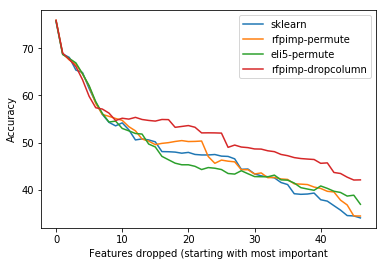

In [49]:
plt=None
import matplotlib.pyplot as plt
plt.plot(res)
plt.ylabel("Accuracy")
plt.xlabel('Features dropped (starting with most important')
plt.gca().legend(('sklearn','rfpimp-permute','eli5-permute','rfpimp-dropcolumn'))
plt.show()

In [50]:
# res

In [51]:
to_keep_eli5P.head()

Series([], Name: columns, dtype: object)

If the feature importance vector is correct then you should have the largest drops in accuracy in the begginning with a leveling off effect as more (and less important) features) are dropped.  eli5-permute is the only one exhibiting that behaviour.<br>
On the other hand there is something definitely wrong with rfpimp-dropcolumn, it has a low drop until it hits a cliff later<br>
This can all be due to multi collinearity, you keep dropping correlated columns, but the remaining ones take up the slack. That is until the last one is dropped, then you get a cliff.
<br><B> Takeaway: eli5 is a solid product. rfpimp is not (it states that its a learning excercise in the docs)</b>

In [52]:
# Wanna see diffs between columns?
# print("diff between last 2")
# set(to_keep_RF)-set(to_keep_DC)

# set(to_keep_DC)-set(to_keep_RF)

# So lets run some predictions with eli5 permutations
just keep the important columns

In [53]:
#first with all columns
to_keep = I[:].reset_index()['columns'];len(to_keep)
rerunWithFewerColumns(to_keep,silent=False);

number of features we are running on=48
[0.8114635157545605, 0.7580845771144279, 0.7551133222775014]
Got 4876 right out of 6432 samples, Accuracy is 75.80845771144278 percent


In [54]:
#now with only the columns that matter
to_keep_mod_rf = I[I.importances>0.0].reset_index()['columns'];len(to_keep_eli5P)
_,mod_rf=rerunWithFewerColumns(to_keep,silent=False)

0

number of features we are running on=48
[0.8114635157545605, 0.7580845771144279, 0.7551133222775014]
Got 4876 right out of 6432 samples, Accuracy is 75.80845771144278 percent


<B>So accuracy goes up if you drop columns that dont matter much.  

## Save this model for later

In [55]:
# save the model to disk
pickle.dump(mod_rf, open(outdir+"/"+filename_model_params, 'wb'))
 
# load the model from disk
mod_rf = pickle.load(open(outdir+"/"+filename_model_params, 'rb'))

# Run multinomial regression to check regression accuracy

In [110]:
from sklearn.linear_model import LogisticRegression

#first with one verses rest
m_mlr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr',max_iter=10000)
m_mlr.fit(trn, trn_y)
print_score(m_mlr, trn, trn_y, tst, tst_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

[0.474571586511885, 0.4717039800995025]


In [111]:
#now with multinomial
m_mlr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',max_iter=10000)
m_mlr.fit(trn, trn_y)
print_score(m_mlr, trn, trn_y, tst, tst_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

[0.5924198452183527, 0.5873756218905473]


# Now that we have a fully trained model (mod_rf  from above) lets see what it  predicts when we permute the input data

Assuming the model has learned a good bit about how people vote. Lets change the inputs and see what it says.

In [115]:
#first lets append train and test together, note, these will be in a different order than original train test set
all = trn.copy().append(tst.copy(), ignore_index=True)
all_y = trn_y.copy().append(tst_y.copy(), ignore_index=True)
all_indexes = trn_indexes.copy().append(tst_indexes.copy(), ignore_index=True)

#lets put the original predictions back
all.insert(0,columns_dep_var,all_y)
all.head()
len(all)
all_indexes.head()
trn.head()

,cc.vote16,index,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_3,cc.CC16_305_2,cc.CC16_305_1,cc.CC16_305_7,cc.CC16_305_5,cc.CC16_305_11,cc.CC16_305_6,cc.CC16_305_9,cc.CC16_305_10,cc.CC16_305_4,cc.fortunesum,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.citylength_1,cc.isimmigrant,cc.child18,cc.milstat_1,cc.milstat_3,cc.union,cc.CC16_300_5,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,eth.his.p,relig.evan.pc,demo.popdense,cc.RepDum,cc.IndDum
0,2,41774,0,0.631982,0.421638,1.555567,2.997609,0.955437,0.746187,1.124623,2.365855,0,0,0,1,0,1,0,0,0,0,1.739794,0.722408,0.850569,0.855920,0.887577,0.0,0.709315,1,1,0,0,0.044401,1,1.0,1.004098,1.047055,0.0,1,0.431581,0.902155,0.0,0.0,0.814553,0.525258,1.139161,0.042193,0.0,0.0
1,0,7379,1,0.947973,0.983823,0.486994,0.283530,0.997454,1.108232,0.867162,0.277401,0,0,0,0,0,0,0,0,0,1,0.869897,1.172766,0.425285,0.962910,0.295859,0.0,0.886644,0,0,1,0,0.888018,1,0.0,0.502049,1.047055,0.0,0,3.021067,1.578771,1.0,0.0,0.995565,1.488613,0.506771,0.087779,1.0,0.0
2,2,31139,0,0.631982,0.843277,0.728483,0.645397,0.747177,1.121927,0.686091,0.753709,0,0,0,0,0,0,0,0,0,1,0.869897,1.034503,0.425285,0.855920,1.183436,0.0,1.458036,0,0,1,1,2.131244,0,0.0,1.004098,1.047055,0.0,0,0.431581,0.676616,0.0,1.0,1.357588,0.308885,0.729800,0.248592,0.0,0.0
3,1,10588,0,0.947973,0.843277,0.673498,1.074265,1.063220,1.072834,0.775212,0.580976,0,0,0,0,0,0,0,0,1,0,-0.869897,0.905313,1.701138,1.069900,1.183436,1.0,1.458036,1,0,1,0,1.598433,0,0.0,1.004098,1.047055,1.0,0,1.294743,1.578771,1.0,0.0,1.448094,0.721752,0.201437,0.166523,1.0,0.0
4,1,23391,0,1.263963,0.562184,1.321577,0.276227,0.639394,0.887516,0.773797,0.098916,0,0,0,0,0,0,0,0,1,0,-0.869897,0.747420,1.701138,1.283881,1.183436,1.0,1.182192,0,0,1,0,1.376428,0,0.0,1.004098,0.523528,0.0,1,0.431581,1.578771,1.0,0.0,0.905059,0.310414,0.633215,0.011432,0.0,1.0


64320

,index
0,41774
1,7379
2,31139
3,10588
4,23391


,index,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_3,cc.CC16_305_2,cc.CC16_305_1,cc.CC16_305_7,cc.CC16_305_5,cc.CC16_305_11,cc.CC16_305_6,cc.CC16_305_9,cc.CC16_305_10,cc.CC16_305_4,cc.fortunesum,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.citylength_1,cc.isimmigrant,cc.child18,cc.milstat_1,cc.milstat_3,cc.union,cc.CC16_300_5,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,eth.his.p,relig.evan.pc,demo.popdense,cc.RepDum,cc.IndDum
0,41774,0,0.631982,0.421638,1.555567,2.997609,0.955437,0.746187,1.124623,2.365855,0,0,0,1,0,1,0,0,0,0,1.739794,0.722408,0.850569,0.855920,0.887577,0.0,0.709315,1,1,0,0,0.044401,1,1.0,1.004098,1.047055,0.0,1,0.431581,0.902155,0.0,0.0,0.814553,0.525258,1.139161,0.042193,0.0,0.0
1,7379,1,0.947973,0.983823,0.486994,0.283530,0.997454,1.108232,0.867162,0.277401,0,0,0,0,0,0,0,0,0,1,0.869897,1.172766,0.425285,0.962910,0.295859,0.0,0.886644,0,0,1,0,0.888018,1,0.0,0.502049,1.047055,0.0,0,3.021067,1.578771,1.0,0.0,0.995565,1.488613,0.506771,0.087779,1.0,0.0
2,31139,0,0.631982,0.843277,0.728483,0.645397,0.747177,1.121927,0.686091,0.753709,0,0,0,0,0,0,0,0,0,1,0.869897,1.034503,0.425285,0.855920,1.183436,0.0,1.458036,0,0,1,1,2.131244,0,0.0,1.004098,1.047055,0.0,0,0.431581,0.676616,0.0,1.0,1.357588,0.308885,0.729800,0.248592,0.0,0.0
3,10588,0,0.947973,0.843277,0.673498,1.074265,1.063220,1.072834,0.775212,0.580976,0,0,0,0,0,0,0,0,1,0,-0.869897,0.905313,1.701138,1.069900,1.183436,1.0,1.458036,1,0,1,0,1.598433,0,0.0,1.004098,1.047055,1.0,0,1.294743,1.578771,1.0,0.0,1.448094,0.721752,0.201437,0.166523,1.0,0.0
4,23391,0,1.263963,0.562184,1.321577,0.276227,0.639394,0.887516,0.773797,0.098916,0,0,0,0,0,0,0,0,1,0,-0.869897,0.747420,1.701138,1.283881,1.183436,1.0,1.182192,0,0,1,0,1.376428,0,0.0,1.004098,0.523528,0.0,1,0.431581,1.578771,1.0,0.0,0.905059,0.310414,0.633215,0.011432,0.0,1.0


In [116]:
def predictAndAppendToDataframe(rf,alldata, toKeep,newColumnName, silent=False):
    '''
    rf: trained random forest
    alldata: entire dataset to predict on (assummes dependant variable is in itemgetter)
    tokeep: the columns to use from alldata, 
            should be the same set of columns that rf was trained on
            if want them all pass in alldata.columns
    newColumnName: where this set of predictions should go

    ''' 
    #Are we using only a subset of the data?
    all_keep = alldata[toKeep].copy()

    #get a baseline estimate
    preds = mod_rf.predict(all_keep)
    
    #generate a new dataset and append these predictions
    all_base=alldata.copy()
    all_base.insert(0,newColumnName,preds)
    all_base.head()
    
    if (silent==False):
        #should be between OOB and training error, probably much closer to training error 
        #since 90% of the dataset was used for it
        eval_accuracy(preds,alldata[columns_dep_var], silent=False)
    return all_base

def predict(rf,alldata, toKeep):
    '''
    rf: trained random forest
    alldata: entire dataset to predict on (assummes dependant variable is in itemgetter)
    tokeep: the columns to use from alldata, 
            should be the same set of columns that rf was trained on
            if want them all pass in alldata.columns
    newColumnName: where this set of predictions should go

    ''' 
    #Are we using only a subset of the data?
    all_keep = alldata[toKeep]

    #get a baseline estimate
    return mod_rf.predict(all_keep)
    
    #generate a new dataset and append these predictions
    all_base=alldata.copy()
    all_base.insert(0,newColumnName,preds)
    all_base.head()
    
    if (silent==False):
        #should be between OOB and training error, probably much closer to training error 
        #since 90% of the dataset was used for it
        eval_accuracy(preds,alldata[columns_dep_var], silent=False)
    return all_base

def predictAndSaveData(mod_rf,alldata,to_keep_mod_rf,outdir,filename):
    '''
    mod_rf: fully trained random forest
    alldata: all data incling unwanted columns
    to_keep_mod_rf:  The only columns to keep in alldata,matches mod_rf expectation
    outdir: directory where file goes
    filename: filename where file goes (expecting .csv)
    '''
    #run predictions
    df=predictAndAppendToDataframe(mod_rf,alldata,to_keep_mod_rf)

    #save dataset as csv
    filename=outdir +'/' + filename
    df.to_csv(filename,encoding = "ISO-8859-1")

## Calculate Control

In [117]:
all = trn.copy().append(tst.copy(), ignore_index=True)
all_y = trn_y.copy().append(tst_y.copy(), ignore_index=True)
all_indexes = trn_indexes.copy().append(tst_indexes.copy(), ignore_index=True)

In [118]:
# all_indexes=None
all_indexes.head()

,index
0,41774
1,7379
2,31139
3,10588
4,23391


In [119]:
#get copy of dataset
tmpData = all[all.columns].copy()

#permute it
preds=predict(mod_rf,tmpData,to_keep)
all_indexes.insert(0,'RF_control',preds)

eval_accuracy(preds,all_y, silent=False);

Got 51850 right out of 64320 samples, Accuracy is 80.61256218905473 percent


In [120]:
len(all_indexes)

64320

In [121]:
all_indexes.head()

,RF_control,index
0,2,41774
1,0,7379
2,2,31139
3,1,10588
4,1,23391


In [122]:
all_indexes.to_feather('tmp/all_indexes_regid31')

## Calculate -Set everyone's cc.BlackDum = 0, predict. Then set it = 1, predict.

In [123]:
#get copy of dataset
tmpData = all[all.columns].copy()

#permute it to 0
tmpData['cc.blackdum']=0
tmpData['cc.WhiteDum']=1
preds=predict(mod_rf,tmpData,to_keep)
all_indexes.insert(0,'RF_blackdum0',preds)
eval_accuracy(preds,all_y, silent=False);

#permute it to 1
tmpData['cc.blackdum']=1
tmpData['cc.WhiteDum']=0
preds=predict(mod_rf,tmpData,to_keep)
all_indexes.insert(0,'RF_blackdum1',preds)
eval_accuracy(preds,all_y, silent=False);

Got 51514 right out of 64320 samples, Accuracy is 80.09017412935323 percent
Got 50774 right out of 64320 samples, Accuracy is 78.93967661691542 percent


In [124]:
all.columns

Index(['index', 'cc.emp.nojob', 'cc.CC16_304', 'cc.faminc', 'crashpc',
       'rustpc', 'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.CC16_305_3', 'cc.CC16_305_2', 'cc.CC16_305_1', 'cc.CC16_305_7',
       'cc.CC16_305_5', 'cc.CC16_305_11', 'cc.CC16_305_6', 'cc.CC16_305_9',
       'cc.CC16_305_10', 'cc.CC16_305_4', 'cc.fortunesum',
       'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum', 'cc.raceviewsum',
       'cc.CC16_307', 'cc.CC16_351B', 'cc.Age', 'cc.Sex', 'cc.BlackDum',
       'cc.WhiteDum', 'cc.maxeduc.4yr', 'cc.citylength_1', 'cc.isimmigrant',
       'cc.child18', 'cc.milstat_1', 'cc.milstat_3', 'cc.union',
       'cc.CC16_300_5', 'cc.newsint', 'cc.Ideo7', 'cc.EvanProt', 'cc.Catholic',
       'cc.Religiosity', 'eth.his.p', 'relig.evan.pc', 'demo.popdense',
       'cc.RepDum', 'cc.IndDum'],
      dtype='object')

## Calculate -Cycle cc.raceviewsum from 1.0 to 5.0 

In [125]:
#find the range of values these can take
minrvs=all['cc.raceviewsum'].min()
rnge =all['cc.raceviewsum'].max()- all['cc.raceviewsum'].min()
inc = rnge/5.0

print(f"minrvs={minrvs} inc={inc}")

minrvs=0.42796019786246897 inc=0.3423681582899762


In [126]:
#NOTE THIS COLUMN IS NOT THERE IF SUMMARY COLUMNS FOR RACE AND IMM DROPPED
#get copy of dataset
tmpData = all[all.columns].copy()

for i in range(5):
    #permute it to 0
    print(str(float(i*inc)+minrvs))
    tmpData['cc.raceviewsum']=float(i*inc)+ minrvs
    columnname = 'ccraceviewsum'+ str(i+1)
    preds=predict(mod_rf,tmpData,to_keep)
    all_indexes.insert(0,columnname,preds)
    eval_accuracy(preds,all_y, silent=False);
    

0.42796019786246897
Got 41059 right out of 64320 samples, Accuracy is 63.835509950248756 percent


63.835509950248756

0.7703283561524452
Got 42198 right out of 64320 samples, Accuracy is 65.60634328358209 percent


65.60634328358209

1.1126965144424212
Got 45431 right out of 64320 samples, Accuracy is 70.63277363184079 percent


70.63277363184079

1.4550646727323975
Got 44598 right out of 64320 samples, Accuracy is 69.33768656716418 percent


69.33768656716418

1.7974328310223737
Got 44544 right out of 64320 samples, Accuracy is 69.25373134328358 percent


69.25373134328358

## Calculate -Cycle  crashpc equal to it's 25th percentile value, then 50th, then 75th percentile value. Predict in each case.

In [127]:
#find the range of values these can take
mincpc=all['crashpc'].min()
rnge =all['crashpc'].max()- all['crashpc'].min()
inc = rnge/5.0

print(f"mincpc={minrvs}, max={all['crashpc'].max()}")
all['crashpc'].describe()

mincpc=0.42796019786246897, max=6.16071334873197


count    64320.000000
mean         0.853837
std          0.519568
min          0.017156
25%          0.498652
50%          0.783605
75%          1.073675
max          6.160713
Name: crashpc, dtype: float64

In [128]:
#get copy of dataset
tmpData = all[all.columns].copy()

pcts=[]
for i in range(3):
    prct=(i+1)*0.25
    pcts.append(tmpData['crashpc'].quantile(prct))
pcts
for i in range(3):
    prct_s = str((i+1)*0.25).replace(".","")
    
    tmpData['crashpc']=pcts[i]
    columnname = 'crashpc_'+ prct_s
    preds=predict(mod_rf,tmpData,to_keep)
    all_indexes.insert(0,columnname,preds)
    eval_accuracy(preds,all_y, silent=False);

[0.498652494415202, 0.7836047850453851, 1.07367539672133]

Got 51611 right out of 64320 samples, Accuracy is 80.24098258706468 percent


80.24098258706468

Got 51615 right out of 64320 samples, Accuracy is 80.24720149253731 percent


80.24720149253731

Got 51627 right out of 64320 samples, Accuracy is 80.26585820895522 percent


80.26585820895522

In [129]:
 #save dataset as csv
all_indexes.to_csv((outdir +'/' + filename),encoding = "ISO-8859-1")

In [130]:
all_indexes.head()
len(all_indexes.columns)

,crashpc_075,crashpc_05,crashpc_025,ccraceviewsum5,ccraceviewsum4,ccraceviewsum3,ccraceviewsum2,ccraceviewsum1,RF_blackdum1,RF_blackdum0,RF_control,index
0,2,2,2,0,0,0,2,2,2,2,2,41774
1,0,0,0,1,1,1,0,0,0,0,0,7379
2,2,2,2,2,2,2,2,2,2,2,2,31139
3,1,1,1,1,1,1,1,1,1,1,1,10588
4,1,1,1,1,1,1,1,1,1,1,1,23391


12

# Merge all_indexes back with original dataset

In [131]:
from utils import merge,replaceNaN

In [132]:
df.head()

,index,crashpc_075,crashpc_05,crashpc_025,ccraceviewsum5,ccraceviewsum4,ccraceviewsum3,ccraceviewsum2,ccraceviewsum1,RF_blackdum1,RF_blackdum0,RF_control,cc.countyfips,cc.V101,cc.commonweight_vv,cc.commonweight_vv_post,cc.commonweight_vv_lgbt,cc.commonweight,cc.commonweight_post,cc.tookpost,cc.lookupzip,cc.inputstate,cc.cdid113,cc.cdid115,cc.countyname,cc.CurrentGovName,cc.CurrentGovParty,cc.CurrentHouseGender,cc.CurrentHouseName,cc.CurrentHouseParty,...,dr.marg.2012,dr.pmarg.2012,dr.ratio.2016,dr.marg.2016,dr.pmarg.2016,pmarg.dif12,pmarg.dif8,marg.dif12,marg.dif8,ratio.dif12,ratio.dif8,RepClosedP,RepPMarch15,TrumpCarson,TrumpKasich,TrumpCruz,TrumpStrength,relig.tot.pc,relig.evan.pc,relig.cath.pc,relig.orth.pc,relig.oth.pc,relig.lds.pc,relig.mslm.pc,relig.ojud.pc,relig.majprt.pc,relig.majchr.pc,relig.bud.pc,relig.hind.pc,demo.popdense
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.990165,0.490168,0.358252,0.415116,0.392297,0.313699,1,1.710309,1.270698,0.293357,0.293375,,Kate Brown,Democratic,M,Peter DeFazio,Democratic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.993253,0.567879,0.470839,0.524566,0.544645,0.516661,1,1.702097,1.270698,0.073339,0.073344,,Kate Brown,Democratic,F,Suzanne Bonamici,Democratic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,0.996015,4.925791,NaN,NaN,8.213954,0.000000,0,1.504748,0.123970,0.146678,0.146687,,Doug Ducey,Republican,F,Martha McSally,Republican,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.996495,0.758395,NaN,0.465872,0.494493,0.000000,0,1.476199,1.518639,0.293357,0.293375,,Gary Herbert,Republican,F,Mia Love,Republican,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,0.996763,0.531301,0.385797,0.445813,0.482130,0.396884,1,1.714380,1.270698,0.146678,0.146687,,Kate Brown,Democratic,M,Greg Walden,Republican,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
df.reset_index(inplace=True)

In [134]:
dftmp=df.copy()

In [135]:
print(f"There are {len(dftmp)} rows in df_s")

There are 64600 rows in df_s


In [136]:
#slap them both together
dftmp = merge(all_indexes,dftmp)

In [137]:

dftmp.head()
len(dftmp)

,crashpc_075_x,crashpc_05_x,crashpc_025_x,ccraceviewsum5_x,ccraceviewsum4_x,ccraceviewsum3_x,ccraceviewsum2_x,ccraceviewsum1_x,RF_blackdum1_x,RF_blackdum0_x,RF_control_x,level_0,crashpc_075_y,crashpc_05_y,crashpc_025_y,ccraceviewsum5_y,ccraceviewsum4_y,ccraceviewsum3_y,ccraceviewsum2_y,ccraceviewsum1_y,RF_blackdum1_y,RF_blackdum0_y,RF_control_y,cc.countyfips,cc.V101,cc.commonweight_vv,cc.commonweight_vv_post,cc.commonweight_vv_lgbt,cc.commonweight,cc.commonweight_post,...,dr.marg.2012,dr.pmarg.2012,dr.ratio.2016,dr.marg.2016,dr.pmarg.2016,pmarg.dif12,pmarg.dif8,marg.dif12,marg.dif8,ratio.dif12,ratio.dif8,RepClosedP,RepPMarch15,TrumpCarson,TrumpKasich,TrumpCruz,TrumpStrength,relig.tot.pc,relig.evan.pc,relig.cath.pc,relig.orth.pc,relig.oth.pc,relig.lds.pc,relig.mslm.pc,relig.ojud.pc,relig.majprt.pc,relig.majchr.pc,relig.bud.pc,relig.hind.pc,demo.popdense
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.990165,0.490168,0.358252,0.415116,0.392297,0.313699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.993253,0.567879,0.470839,0.524566,0.544645,0.516661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,0.996015,4.925791,NaN,NaN,8.213954,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.996495,0.758395,NaN,0.465872,0.494493,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,0.996763,0.531301,0.385797,0.445813,0.482130,0.396884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


64600

## Drop NaN rows for testing

In [138]:
df1=dftmp.copy()

In [139]:
print(f"There are {len(df1)} rows in df_s")

#dump the NaN rows
df1 = df1[pd.notnull(df1['cc.vote16'] )]
print(f"There are {len(df1)} rows in df_s after removing rows with Nan for dependant variable")

There are 64600 rows in df_s
There are 64320 rows in df_s after removing rows with Nan for dependant variable


## Convert cc.vote16 back to categorical

In [140]:
#how many unique values?
unique_vals = dftmp['cc.vote16'].unique()
unique_vals
# rray([1.776907, 0.592302, 0.      , 1.184605, 2.961511, 2.369209, 3.553814])

array([1.776907, 0.592302, 0.      , 1.184605, 2.961511, 2.369209, 3.553814,      nan])

In [141]:
#cc.vote16 seems to have been scaled incorrectly, it should be categorical, convert it back
#1/std_dev = .592302
mult = 1/0.592302

#multiply col by mult to get close to original value
df1['cc.vote16'] = (df1['cc.vote16']*mult).astype('int64')

In [142]:
#is the dataset balanced?
df_vc= dftmp['cc.vote16'].value_counts()
df_vc
df_vc.sum()
df_vc[0]

1.184605    22136
0.000000    19389
0.592302    18754
1.776907     1829
3.553814     1136
2.369209      913
2.961511      163
Name: cc.vote16, dtype: int64

64320

19389

In [143]:
for col in all_indexes.columns:
    if col == 'index':
        continue
    df1.loc[:,col] = df1.loc[:,col].astype('Int64')
df1['cc.vote16'] = df1['cc.vote16'].astype('Int64')

# unique_vals_unnormalized = unique_vals*std_dev
# unique_vals_unnormalized
# unique_vals_unnormalized = unique_vals_unnormalized.astype('int64')
# unique_vals_unnormalized

(df1['RF_control']==df1['cc.vote16']).sum()/(len(df1))

KeyError: 'the label [crashpc_075] is not in the [columns]'

In [ ]:
df1.head()

## Save Dataset to csv file

In [ ]:
dftmp1 = dftmp.copy()
dftmp1=dftmp.loc[:,None:'RF_control']
dftmp1.head()
len(dftmp1)

In [ ]:
 #save dataset as csv
filename_small='Results.csv'
dftmp1.to_csv((outdir +'/' + filename_small),encoding = "ISO-8859-1")

## Checks

In [ ]:
#checks
df = pd.read_csv((outdir +'/' + filename_all),encoding = "ISO-8859-1")

In [ ]:
df.head()

In [ ]:
len(df)
df.duplicated().sum()
#lets see how many columns, how many have no and some missing values
print (f"Total columns={len(df.columns)}")
print(f"Total columns with no Nans= {len(df.columns[~df.isnull().any()])}") 
print(f"Total columns with Nans= {len(df.columns[df.isnull().any()])}") #add ~ to get columns with no missing values

In [ ]:
#same number of missing ?
df['cc.vote16'].isna().sum()
df['ccraceviewsum5'].isna().sum()

In [ ]:
#how many unique values?
unique_vals = df['cc.vote16'].unique()
unique_vals

In [ ]:
df3=df[['RF_control','cc.vote16']]
df3=df3[df3['cc.vote16'].notnull()]

In [ ]:
df3['RF_control'] = df3['RF_control'].astype('int64')

In [ ]:
df3

In [ ]:
mult = 1/0.592302

#multiply col by mult to get close to original value
 
df3['cc.vote16'] = (df3['cc.vote16']*mult).astype('int64')

# unique_vals_unnormalized = unique_vals*std_dev
# unique_vals_unnormalized
# unique_vals_unnormalized = unique_vals_unnormalized.astype('int64')
# unique_vals_unnormalized

In [ ]:
(df['RF_control']==df['cc.vote16']).sum()/(len(df3))

In [ ]:
df2 = df.loc[pd.isnull(df['cc.vote16'])]
df3 = df.loc[pd.isnull(df['ccraceviewsum5'])]
df2.head()
df3.head()

# Remove redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. You should be able to remove these correlated features without degrading the OOB score (or R**2 or accuracy) of the model.  In fact the model is simpler so its performence may go up.

The following dendrogram using spearman ranked correlation to get correlations between features.  Start from the right and see which features combine, those are closer together in rank than those not on that fork.  For an excellent overview see <a href="https://www.statisticshowto.datasciencecentral.com/hierarchical-clustering/"> Hierarchical Clustering / Dendrogram</a></strong>

In [ ]:
from scipy.cluster import hierarchy as hc

In [ ]:
corr = np.round(scipy.stats.spearmanr(trn).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,15))
dendrogram = hc.dendrogram(z, labels=trn.columns, orientation='left', leaf_font_size=16)
plt.show()

Notice the x axis starts at 1 and goes to 0.  If 2 features are linked at or near 0 then they are highly correlated.  

In [ ]:
def get_oob(df,y):
    m= RandomForestClassifier(n_estimators=100,  min_samples_leaf=10, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

#get unaltered score
get_oob(trn, trn_y)

Hmmm... Not much savings here.  

# Partial Dependence

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
#NOTE THIS COLUMN IS NOT THERE IF SUMMARY COLUMNS FOR RACE AND IMM DROPPED
#looks like cc.raceviewsum matters a lot, lets plot it against dependent var
ax = trn_raw[:40000].plot.hexbin(x='cc.raceviewsum', y=columns_dep_var, gridsize=20,figsize=(10,5) )

In [ ]:
trn_raw['cc.raceviewsum'].min()
trn_raw['cc.raceviewsum'].max()

In [ ]:
import matplotlib.font_manager
def plot_pdp(feat, m, x, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)


In [ ]:
plot_pdp('cc.raceviewsum', m_rf, trn[:500])
# plot_pdp('cc.cc16_422d', m_rf, trn[:500])
# plot_pdp('cc.cc16_422e', m_rf, trn[:500])
plot_pdp('cc.ideo7', m_rf, trn[:500])
# plot_pdp('cc.cc16_422f', m_rf, trn[:500])
plot_pdp('cc.repdum', m_rf, trn[:500])
plot_pdp('cc.immviewsum', m_rf, trn[:500])
plot_pdp('cc.blackdum', m_rf, trn[:500])   #this is a bool, only 2 values so pdp should be linear

In [ ]:
# feats=['cc.ideo7','cc.raceviewsum']
#feats=['cc.repdum','cc.CC16_422d']
p=pdp.pdp_interact(m_rf, trn, feats)
pdp.pdp_interact_plot(p, feats)

# Conclusions and Next Steps
This model is 78% accurate with no data tweaks

# Scratch

In [ ]:
data = test[0]
data[31]
type(data)
data.shape
tmp=learn.predict(data)
len(tmp)
out,pred,res=tmp

out
pred
res

# len(out)
# len(pred)
len(res)